In this notebook, I will train and test my custom SRL model on the UniteD-SRL dataset in order to have a baseline for the noUniteD-SRL dataset creation.

# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
datasets_root_path = './datasets/'
srl_dataset_path = os.path.join(datasets_root_path, 'united-srl')
checkpoints_dir_path = './checkpoints/'
model_dir_path = os.path.join(checkpoints_dir_path, 'models_united')

srl_dataset_dict_paths = {}
for lang in os.listdir(srl_dataset_path):
    dataset_lang_path = os.path.join(srl_dataset_path, lang)
    if os.path.isdir(dataset_lang_path):
        srl_dataset_dict_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            srl_dataset_dict_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'transformer_name': "xlm-roberta-base",
}

# Predicate Identification and Disambiguation

## Dataset

In [6]:
from code_files.datasets.dataset_united import DatasetUniteD

In [7]:
dataset_train_en_pid = DatasetUniteD(  srl_dataset_dict_paths['EN']['train'], split_predicates=False )
dataset_dev_en_pid = DatasetUniteD(  srl_dataset_dict_paths['EN']['dev'], split_predicates=False )

In [8]:
global_params.update({
    'n_roles_labels': len(dataset_train_en_pid.id_to_roles),
    'n_predicates_labels': len(dataset_train_en_pid.id_to_predicates),

    'id_to_roles': dataset_train_en_pid.id_to_roles,
    'roles_to_id': dataset_train_en_pid.roles_to_id,
    'roles_pad_id': dataset_train_en_pid.roles_pad_id,
    'roles_pad': dataset_train_en_pid.roles_pad,

    'id_to_predicates': dataset_train_en_pid.id_to_predicates,
    'predicates_to_id': dataset_train_en_pid.predicates_to_id,
    'predicates_pad_id': dataset_train_en_pid.predicates_pad_id,
    'predicates_pad': dataset_train_en_pid.predicates_pad,
})

In [9]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

In [10]:
len(dataset_train_en_pid.data), len(dataset_dev_en_pid.data)

(5501, 1026)

In [11]:
print(dataset_train_en_pid[0],'\n\n',dataset_dev_en_pid[0])

{'dependency_heads': [3, 3, 0, 8, 7, 7, 8, 3, 10, 8, 13, 13, 10, 3], 'dependency_relations': ['nsubj', 'advmod', 'root', 'mark', 'det', 'amod', 'nsubj', 'ccomp', 'amod', 'obj', 'case', 'amod', 'nmod', 'punct'], 'lemmas': ['member', 'also', 'ask', 'whether', 'all', 'social', 'group', 'enjoy', 'equal', 'access', 'to', 'higher', 'education', '.'], 'pos_tags': ['NOUN', 'ADV', 'VERB', 'SCONJ', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT'], 'predicates': ['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', 'BENEFIT_EXPLOIT', '_', '_', '_', '_', '_', '_'], 'roles': {'2': ['agent', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], '7': ['_', '_', '_', '_', '_', '_', 'beneficiary', '_', '_', 'theme', '_', '_', '_', '_']}, 'words': ['Members', 'also', 'asked', 'whether', 'all', 'social', 'groups', 'enjoyed', 'equal', 'access', 'to', 'higher', 'education', '.']} 

 {'dependency_heads': [2, 3, 0, 8, 7, 7, 8, 3, 10, 8, 12, 8, 14, 12, 19, 19, 18, 19, 14, 21

## Dataloader

In [12]:
from torch.utils.data import DataLoader

dataloader_train_en_pid = DataLoader(
    dataset_train_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_pid.create_collate_fn(),
    shuffle=True,
)

dataloader_dev_en_pid = DataLoader(
    dataset_dev_en_pid,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_pid.create_collate_fn(),
    shuffle=False,
)

In [13]:
for e in dataloader_dev_en_pid:
    ex_in = e
    break

In [14]:
print(ex_in['words'][1], '\n', ex_in['predicates'][1], '\n', ex_in['predicates_positions'][1])

['The', 'Committee', 'insists', 'that', 'all', 'perpetrators', 'of', 'violations', 'of', 'the', 'Convention', 'be', 'brought', 'to', 'justice', '.'] 
 ['_', '_', 'CAUSE-MENTAL-STATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BRING', '_', '_', '_'] 
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


## Training the Predicate Identification and Disambiguation model

In [15]:
loss_function_pid = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_pid.predicates_pad_id) # !

In [16]:
from code_files.models.model_pid import ModelPID
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_pid = ModelPID(
    loss_fn = loss_function_pid,
    hparams = global_params,
    fine_tune_transformer = True,
    has_predicates_positions = False # it does both pred iden and disamb
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
optimizer_pid = optim.SGD(model_pid.parameters(), lr=0.0016, momentum=0.9) 

In [18]:
print_summary(model_pid, short=True)

parameters: 278,376,625
trainable parameters: 278,376,625
non-trainable parameters: 0


In [20]:
history = {}

In [24]:
from code_files.utils.Trainer_pid import Trainer_pid

trainer_pid = Trainer_pid()

history = trainer_pid.train(
    model_pid, optimizer_pid, dataloader_train_en_pid, dataloader_dev_en_pid,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'pid_transformer_united.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.040000
# Validation loss => 0.078706 | f1-score: pred_iden = 0.942830 pred_dis = 0.821559 #
Epoch   1 => avg_loss: 0.039237
# Validation loss => 0.079156 | f1-score: pred_iden = 0.943462 pred_dis = 0.822308 #
Epoch   2 => avg_loss: 0.039353
# Validation loss => 0.078551 | f1-score: pred_iden = 0.940994 pred_dis = 0.820264 #
Epoch   3 => avg_loss: 0.038785
# Validation loss => 0.077965 | f1-score: pred_iden = 0.943657 pred_dis = 0.823687 #
Epoch   4 => avg_loss: 0.038512
# Validation loss => 0.080900 | f1-score: pred_iden = 0.940725 pred_dis = 0.822175 #
Epoch   5 => avg_loss: 0.037705
# Validation loss => 0.079601 | f1-score: pred_iden = 0.942311 pred_dis = 0.825005 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.037416
# Validation loss => 0.079039 | f1-score: pred_iden = 0.942178 pred_dis = 0.824212 #
Epoch   7 => avg_loss: 0.037160
# Validation loss => 0.080219 | f1-score: pred_iden = 0.942219 pred_dis = 0.823190 #
Epoch   8 => avg_l

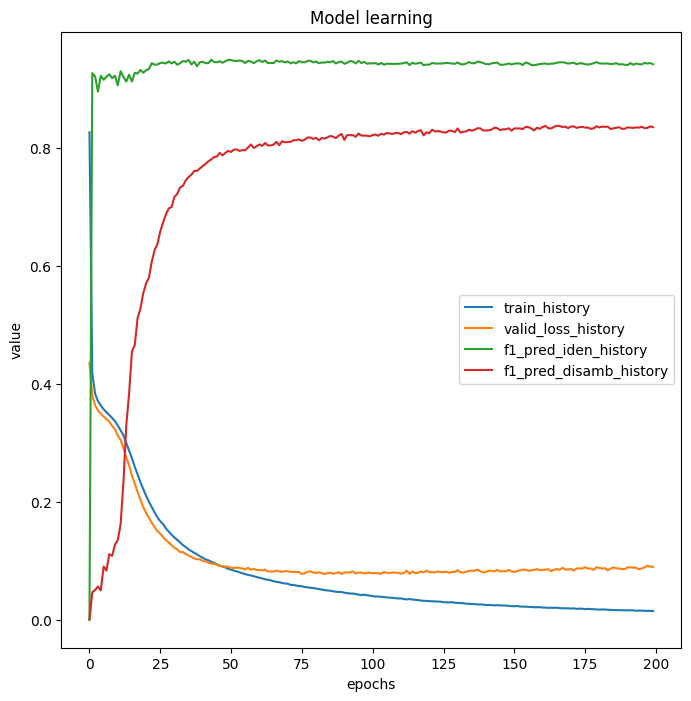

In [25]:
trainer_pid.display_history(history)

In [26]:
print(model_pid.predict([["He","urges","the","Government","to","take","measures","to","protect","persons","who","have","received","death","threats","."]])[0])

['_', 'OBLIGE_FORCE', '_', '_', '_', 'CARRY-OUT-ACTION', '_', '_', 'PROTECT', '_', '_', '_', 'RECEIVE', '_', '_', '_']


In [27]:
print(["_","OBLIGE_FORCE","_","_","_","CARRY-OUT-ACTION","_","_","PROTECT","_","_","_","RECEIVE","_","_","_"])

['_', 'OBLIGE_FORCE', '_', '_', '_', 'CARRY-OUT-ACTION', '_', '_', 'PROTECT', '_', '_', '_', 'RECEIVE', '_', '_', '_']


# Argument Identification and Classification

## Dataset

In [9]:
from code_files.datasets.dataset_united import DatasetUniteD

In [10]:
dataset_train_en_aic = DatasetUniteD(  srl_dataset_dict_paths['EN']['train'], split_predicates=True )
dataset_dev_en_aic = DatasetUniteD(  srl_dataset_dict_paths['EN']['dev'], split_predicates=True )

In [11]:
len(dataset_train_en_aic.data), len(dataset_dev_en_aic.data)

(12562, 2553)

In [12]:
print(dataset_train_en_aic[0],'\n\n',dataset_dev_en_aic[0])

{'dependency_heads': [3, 3, 0, 8, 7, 7, 8, 3, 10, 8, 13, 13, 10, 3], 'dependency_relations': ['nsubj', 'advmod', 'root', 'mark', 'det', 'amod', 'nsubj', 'ccomp', 'amod', 'obj', 'case', 'amod', 'nmod', 'punct'], 'lemmas': ['member', 'also', 'ask', 'whether', 'all', 'social', 'group', 'enjoy', 'equal', 'access', 'to', 'higher', 'education', '.'], 'pos_tags': ['NOUN', 'ADV', 'VERB', 'SCONJ', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT'], 'predicates': ['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': ['agent', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'words': ['Members', 'also', 'asked', 'whether', 'all', 'social', 'groups', 'enjoyed', 'equal', 'access', 'to', 'higher', 'education', '.'], 'predicate_word': ['asked'], 'predicate_name': ['ASK_REQUEST']} 

 {'dependency_heads': [2, 3, 0, 8, 7, 7, 8, 3, 10, 8, 12, 8, 14, 12, 19, 19, 18, 19, 14, 21, 19, 24, 24, 19, 27, 27, 19, 3], 'dependency_re

## Dataloader

In [13]:
from torch.utils.data import DataLoader

dataloader_train_en_aic = DataLoader(
    dataset_train_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_aic.create_collate_fn(),
    shuffle=True,
)

dataloader_dev_en_aic = DataLoader(
    dataset_dev_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_aic.create_collate_fn(),
    shuffle=False,
)

In [14]:
for e in dataloader_dev_en_aic:
    ex_in = e
    break

In [15]:
smpl_idx = 11
print(ex_in['words'][smpl_idx], '\n', ex_in['predicate_name'][smpl_idx], ex_in['predicate_word'][smpl_idx], '\n', ex_in['predicates_positions'][smpl_idx], '\n', ex_in['roles'][smpl_idx])

['He', 'urges', 'the', 'Government', 'to', 'take', 'measures', 'to', 'protect', 'persons', 'who', 'have', 'received', 'death', 'threats', '.'] 
 ['OBLIGE_FORCE'] ['urges'] 
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
 ['agent', '_', '_', 'patient', 'goal', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


## Training the Argument Identification and Classification model

In [16]:
loss_function_aic = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_aic.predicates_pad_id) # !

In [17]:
from code_files.models.model_aic import ModelAIC
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_aic = ModelAIC(
    loss_fn = loss_function_aic,
    hparams = global_params,
    fine_tune_transformer = True
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
optimizer_aic = optim.SGD(model_aic.parameters(), lr=0.0016, momentum=0.9) 

In [19]:
print_summary(model_aic, short=True)

parameters: 278,065,180
trainable parameters: 278,065,180
non-trainable parameters: 0


In [20]:
history = {}

In [21]:
from code_files.utils.Trainer_aic import Trainer_aic

trainer_aic = Trainer_aic()

history = trainer_aic.train(
    model_aic, optimizer_aic, dataloader_train_en_aic, dataloader_dev_en_aic,
    epochs=200, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_united.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.353952
# Validation loss => 0.212124 | f1-score: arg_iden = 0.092302 arg_class = 0.060912 #
Epoch   1 => avg_loss: 0.190178
# Validation loss => 0.124605 | f1-score: arg_iden = 0.835678 arg_class = 0.478474 #
Epoch   2 => avg_loss: 0.137021
# Validation loss => 0.110123 | f1-score: arg_iden = 0.865684 arg_class = 0.509861 #
Epoch   3 => avg_loss: 0.121982
# Validation loss => 0.102325 | f1-score: arg_iden = 0.874049 arg_class = 0.579435 #
Epoch   4 => avg_loss: 0.112756
# Validation loss => 0.097553 | f1-score: arg_iden = 0.881951 arg_class = 0.603204 #
Epoch   5 => avg_loss: 0.106518
# Validation loss => 0.093329 | f1-score: arg_iden = 0.892468 arg_class = 0.617674 #
Epoch   6 => avg_loss: 0.101072
# Validation loss => 0.088881 | f1-score: arg_iden = 0.895047 arg_class = 0.642103 #
Epoch   7 => avg_loss: 0.095848
# Validation loss => 0.085652 | f1-score: arg_iden = 0.893409 arg_class = 0.664158 #
Epoch   8 => avg_loss: 0.090981
# Validation loss => 0.080689 | 

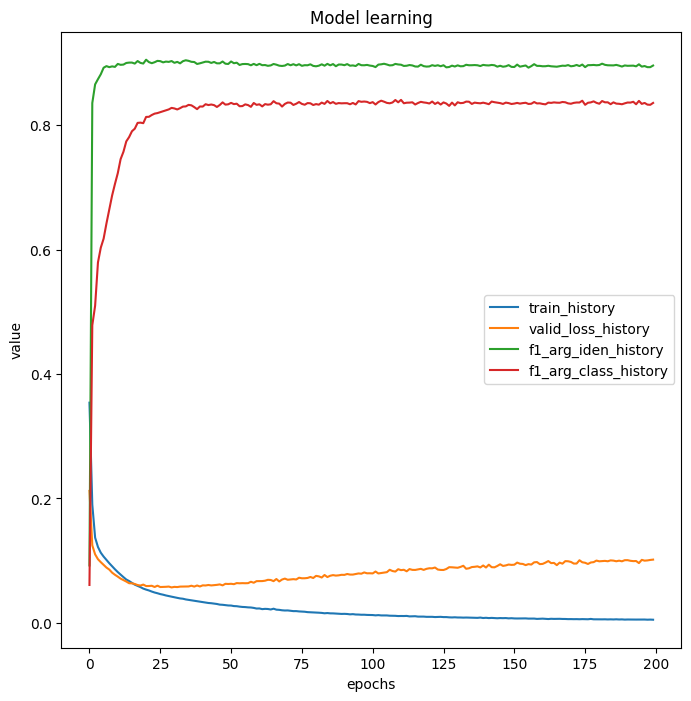

In [22]:
trainer_aic.display_history(history)

In [32]:
print(model_aic.predict([["The","Committee","insists","that","all","perpetrators","of","violations","of","the","Convention","be","brought","to","justice","."]], [["insists"]])[0])
print(["_","agent","_","theme","_","_","_","_","_","_","_","_","_","_","_","_"])

['_', 'agent', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', 'agent', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']
